In [1]:
import os
import time
import numpy as np
import pandas as pd
import preprocessor as p
from st_dbscan import ST_DBSCAN
import matplotlib.pyplot as plt

In [2]:
# Set data directory
data_dir = os.path.realpath("../data")

# Check if file exists
if os.path.exists(os.path.join(data_dir, "tweets.h5")):
    # Read tweets from htweets5
    tweets = pd.read_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")
else:
    # Convert tweets to htweets5
    # ? hdf manages large data well
    tweets = pd.read_csv(os.path.join(data_dir, "tweets.csv"))
    tweets.to_hdf(os.path.join(data_dir, "tweets.h5"), "tweets")

# Remove null longitude and latitude values
tweets = tweets[tweets["longitude"].notnull()]

# Constrain the area to France
tweets = tweets.loc[
    (tweets.latitude > 42.33278)
    & (tweets.latitude < 51.08917)
    & (tweets.longitude > -4.795556)
    & (tweets.longitude < 8.230556)
]

# Set preprocessor options
p.set_options(p.OPT.URL)

# Remove URLs from the tweets
tweets['text'] = tweets['text'].apply(lambda x: p.clean(x))

# Set index to id for easy matching
tweets.set_index('id', inplace=True, verify_integrity=False)

In [3]:
# normalize the data 
# ! Test whether normalization speeds up the algorithm
tweets['longitude'] = (tweets['longitude'] - tweets['longitude'].min()) / (tweets['longitude'].max() - tweets['longitude'].min())
tweets['latitude'] = (tweets['latitude'] - tweets['latitude'].min()) / (tweets['latitude'].max() - tweets['latitude'].min())

# Convert to timestamp
tweets['createdAt'] = pd.to_datetime(tweets['createdAt'])
tweets['ts'] = tweets['createdAt'].values.astype(np.int64) // 10 ** 9

# transform to numpy array
data = tweets.loc[:, ['ts','longitude','latitude']].values

In [4]:
# Apply ST-DBSCAN
start = time.time()
st_dbscan = ST_DBSCAN(eps1 = 0.1, eps2 = 60*10, min_samples = 10).fit(data)
end = time.time()
print("Time taken: ", end - start)
print("Number of clusters: {}".format(len(set(st_dbscan.labels))))

Time taken:  1.3490021228790283
Number of clusters: 17


In [5]:
def plot(data, labels):
    colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a']
    
    for i in range(-1, len(set(labels))):
        if i == -1:
            col = [0, 0, 0, 1]
        else:
            col = colors[i % len(colors)]
        
        clust = data[np.where(labels==i)]
        plt.scatter(clust[:,0], clust[:,1], c=[col], s=1)
    plt.show()

    return None

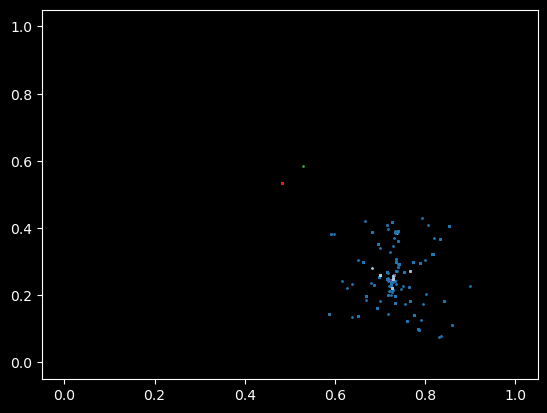

In [6]:
plot(data[:,1:], st_dbscan.labels)